In [2]:
from google.colab import files
uploaded = files.upload()


Saving diabetic data.csv to diabetic data (3).csv


In [3]:
import pandas as pd

df = pd.read_csv("diabetic data.csv")  # Use the exact name that shows up after upload
print(df.head())  # Preview the data


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 194.8 KB


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = df.columns

In [6]:
df['Outcome'].value_counts()

,count
Outcome,
0,1816
1,952


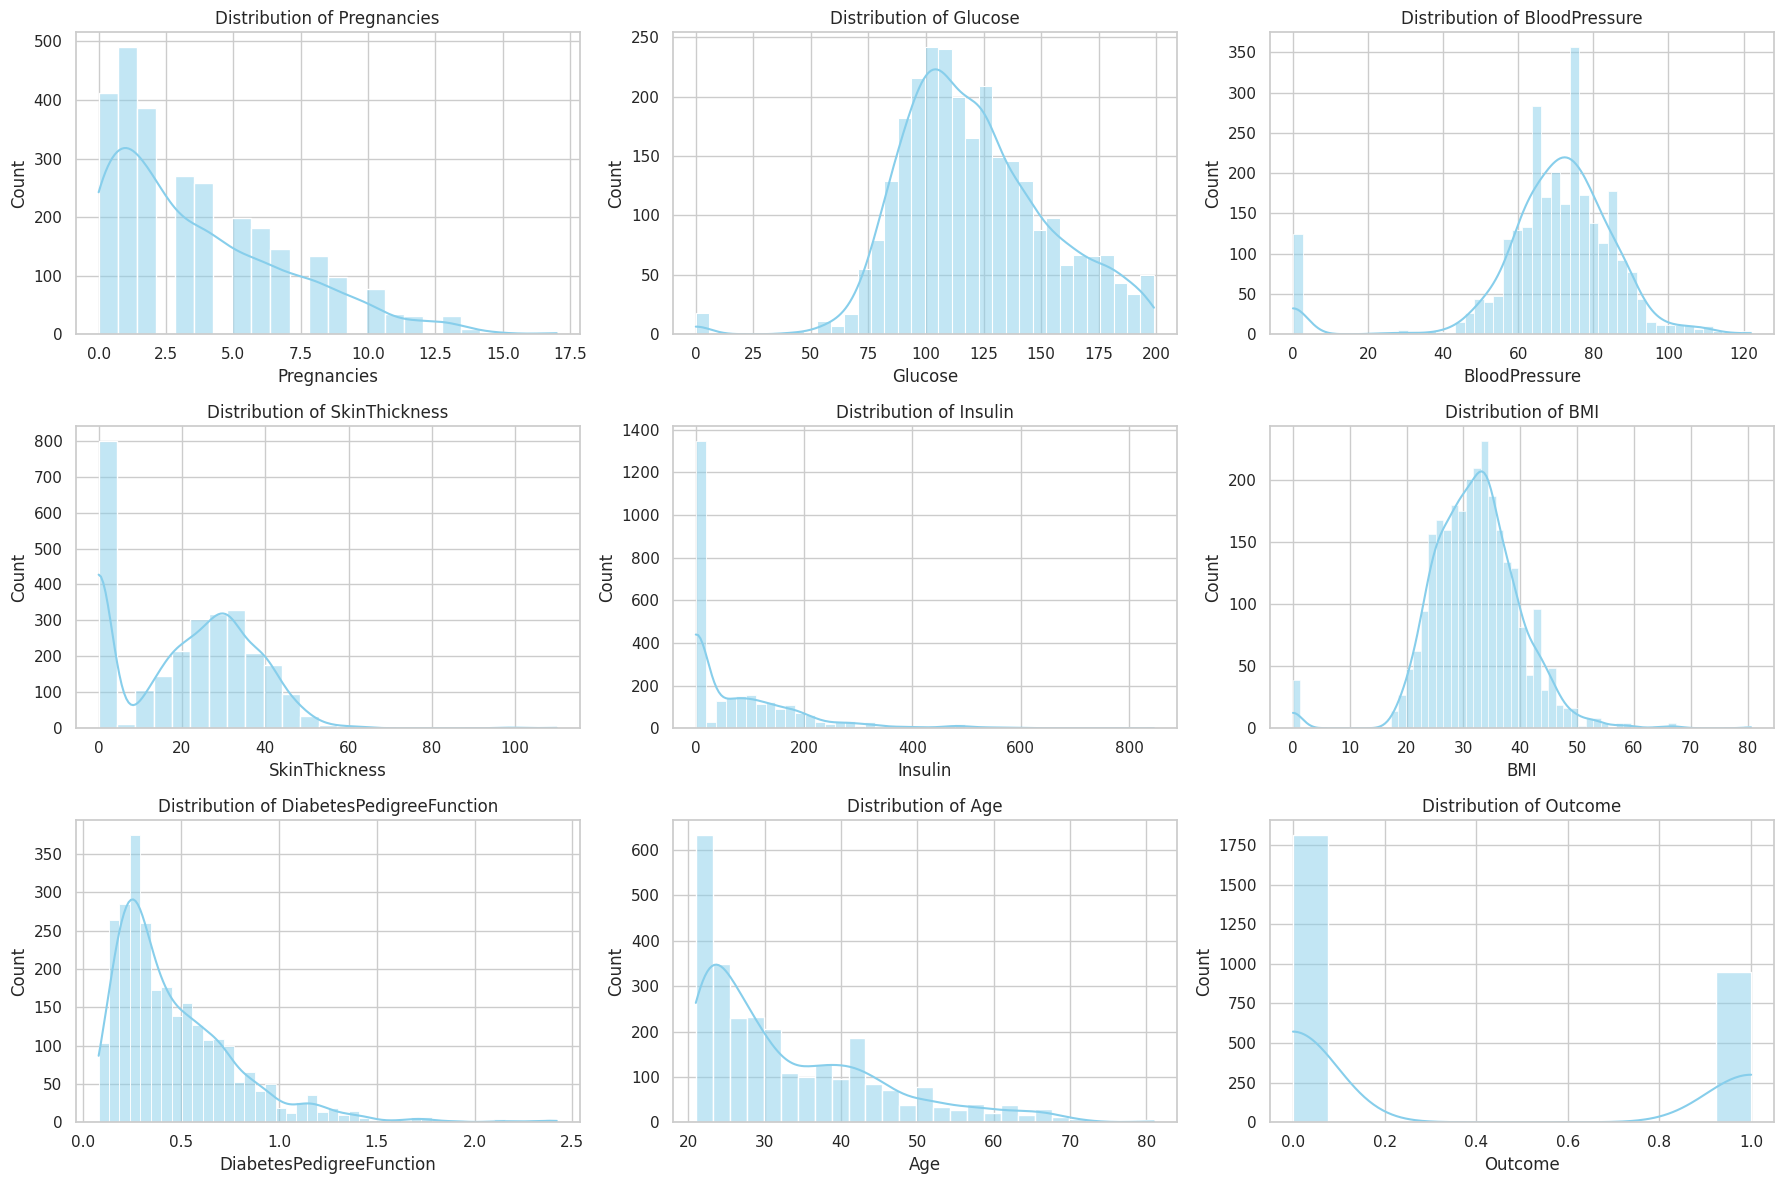

In [7]:
# Set plot style
sns.set(style="whitegrid")
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()
# Plot distribution for each column
for i, col in enumerate(columns):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']
# Apply SMOTE on entire dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check class distribution after SMOTE
from collections import Counter
print("✅ After SMOTE:", Counter(y_resampled))


✅ After SMOTE: Counter({1: 1816, 0: 1816})


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Define model and parameter grid
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'max_depth': [3, 5, 10, None],  # The maximum depth of the tree
    'min_samples_split': [2, 5, 10], # the minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]   # The minimum number of samples required to be at a leaf node
}

# Step 2: Grid Search CV
grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Step 3: Fit to training data
grid_search.fit(X_train, y_train)

# Step 4: Best model
best_model = grid_search.best_estimator_
print("✅ Best Parameters:", grid_search.best_params_)

# ====================== CUSTOM THRESHOLD SECTION ======================

# Step 5: Get predicted probabilities for both sets
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_proba_train = best_model.predict_proba(X_train)[:, 1]

# Step 6: Threshold tuning (on test set)
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_score = -1

for thresh in thresholds:
    y_test_pred_thresh = (y_proba_test >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_thresh).ravel()

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    score = tpr * (1 - fpr)

    if score > best_score:
        best_score = score
        best_threshold = thresh

# Step 7: Final predictions using best threshold
y_test_final = (y_proba_test >= best_threshold).astype(int)
y_train_final = (y_proba_train >= best_threshold).astype(int)

# Step 8: Final evaluation (custom threshold)
print("\n🚀 Custom Threshold Selection")
print("✅ Best Threshold Based on TPR × (1 - FPR):", round(best_threshold, 3))

print("\n✅ Training Accuracy (Custom Threshold):", accuracy_score(y_train, y_train_final))
print("✅ Test Accuracy (Custom Threshold):", accuracy_score(y_test, y_test_final))

print("\n✅ Training Classification Report (Custom Threshold):\n", classification_report(y_train, y_train_final))
print("✅ Test Classification Report (Custom Threshold):\n", classification_report(y_test, y_test_final))

print("✅ Confusion Matrix (Train, Custom Threshold):\n", confusion_matrix(y_train, y_train_final))
print("✅ Confusion Matrix (Test, Custom Threshold):\n", confusion_matrix(y_test, y_test_final))


✅ Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

🚀 Custom Threshold Selection
✅ Best Threshold Based on TPR × (1 - FPR): 0.01

✅ Training Accuracy (Custom Threshold): 1.0
✅ Test Accuracy (Custom Threshold): 0.9903713892709766

✅ Training Classification Report (Custom Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1452
           1       1.00      1.00      1.00      1453

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905

✅ Test Classification Report (Custom Threshold):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       364
           1       1.00      0.98      0.99       363

    accuracy                           0.99       727
   macro avg       0.99      0.99      0.99       727
weighted

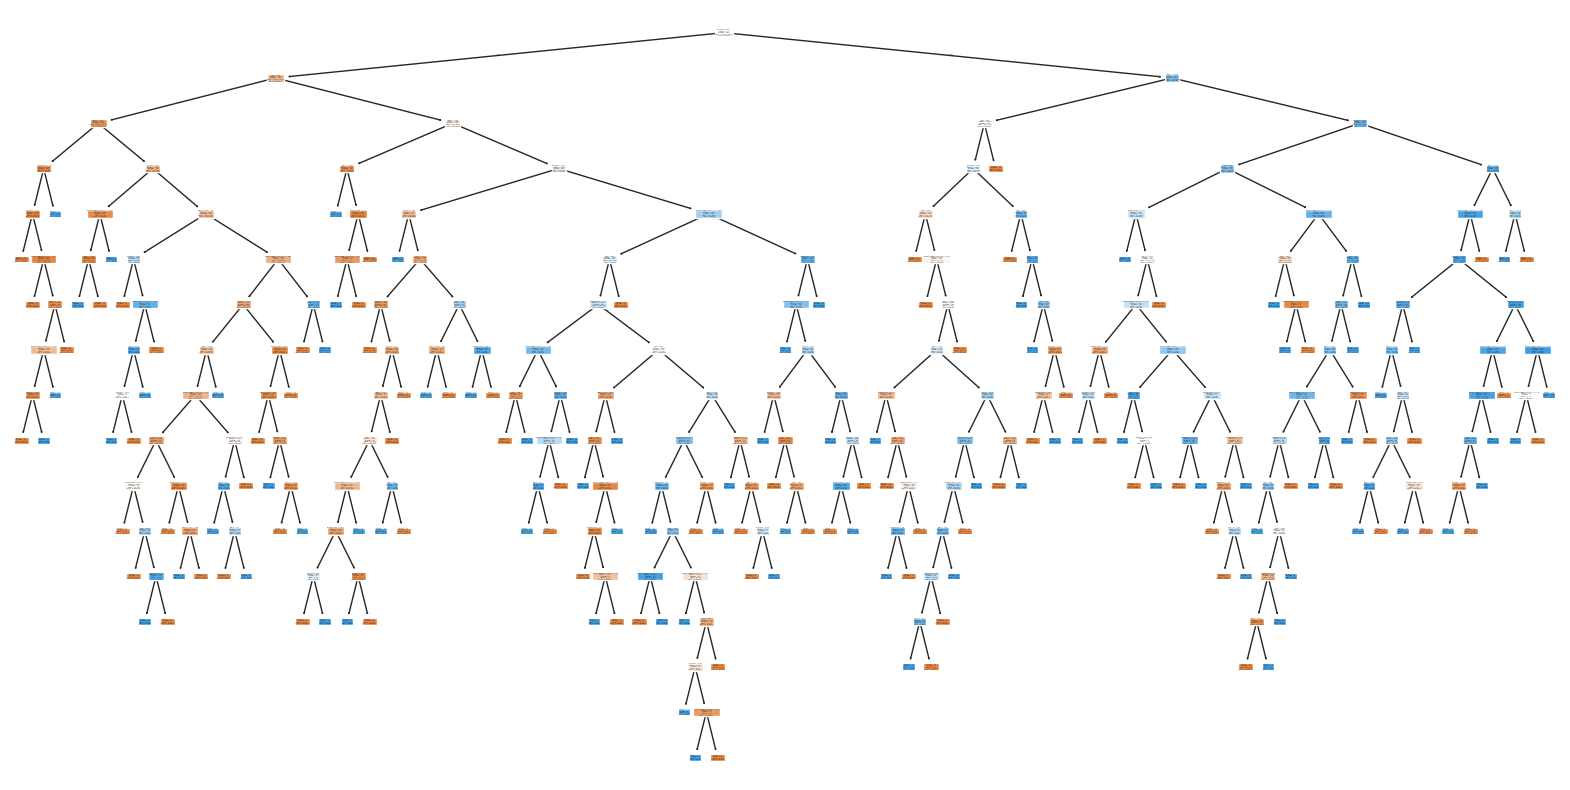

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=X_train.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.show()

# Textual representation of Decision Tree .

In [12]:
from sklearn.tree import export_text

# Display the rules of the tree in text format
tree_rules = export_text(best_model, feature_names=list(X_train.columns))
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 30.95
|   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |--- Glucose <= 104.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Glucose >  104.50
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.41
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DiabetesPedigreeFunction >  0.41
|   |   |   |   |   |   |--- Insulin <= 70.00
|   |   |   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.51
|   |   |   |   |   |   |   |   |--- Glucose <= 121.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Glucose >  121.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- DiabetesPedigreeFunction >  0.51
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Insulin >  70.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- Pregnancies >  7.50
|   |   |   |   |--- class: 1
|   |   |--- BMI >  30.95
|   |   |  

In [13]:
# 1st time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    roc_curve, classification_report, confusion_matrix,
    accuracy_score, roc_auc_score
)
import numpy as np

# Grid search
param_grid = {
    'n_estimators': [50 , 100, 200], # The number of  decision trees in the forest.
    'max_depth': [None, 10, 20], # The maximum depth in all the decision tree
    'min_samples_split': [2, 5], # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5], # The minimum number of samples required to be at a leaf node
    'bootstrap': [True, False], # If False, the whole dataset is used to build each tree.
    "criterion": ["gini", "entropy"], # The function to measure the quality of a split
    "max_features": ["sqrt", "log2"] # The number of features to consider when looking for the best split
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

# ✅ Find best threshold on train data
def best_threshold_by_tpr_1minusfpr(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    scores = tpr * (1 - fpr)
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

# Train set prediction probabilities
y_train_proba = best_rf.predict_proba(X_train)[:, 1]
train_threshold, _ = best_threshold_by_tpr_1minusfpr(y_train, y_train_proba)
y_train_pred = (y_train_proba >= train_threshold).astype(int)

# ✅ Apply the same threshold on test data
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= train_threshold).astype(int)  # <- important fix

# ✅ Evaluation function
def evaluate_model(name, y_true, y_pred, y_proba, threshold):
    print(f"\n📈 Evaluation on {name} Data")
    print(f"✅ Threshold Used: {threshold:.4f}")
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("✅ Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("✅ Classification Report:\n", classification_report(y_true, y_pred))

# ✅ Evaluate
evaluate_model("Train", y_train, y_train_pred, y_train_proba, train_threshold)
evaluate_model("Test", y_test, y_test_pred, y_test_proba, train_threshold)  # <- threshold reused


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
✅ Best Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📈 Evaluation on Train Data
✅ Threshold Used: 1.0000
✅ Accuracy: 1.0000
✅ AUC: 1.0000
✅ Confusion Matrix:
 [[1452    0]
 [   0 1453]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1452
           1       1.00      1.00      1.00      1453

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905


📈 Evaluation on Test Data
✅ Threshold Used: 1.0000
✅ Accuracy: 0.9010
✅ AUC: 1.0000
✅ Confusion Matrix:
 [[364   0]
 [ 72 291]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       364
           1 

In [14]:
! pip install xgboost

# Doing Cross Validation and obtain the best model in XGBoost Classification

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve
)
import numpy as np

# ✅ Step 1: Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],# The number of boosting stages to perform
    'max_depth': [3, 5, 7, 10], #  The maximum depth limits the number of nodes in the tree.
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Learning rate shrinks the contribution of each tree by learning_rate.
    'subsample': [0.6, 0.8, 1.0], # while making decision tree say floor(0.6*N) data will be selected randomly for DT on residuals
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.25, 1.0], # Minimum loss reduction to allow a split.
    'max_features': ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
    'reg_lambda': [1, 5, 10],  # regularization lambda in similarity score
    'criterion': ['friedman_mse','squared_error'], # The function to measure the quality of a split
    'min_samples_split' : [2,3,4,5] # The minimum number of samples required to split an internal node
}

# ✅ Step 2: Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# ✅ Step 3: Randomized Search
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   scoring='roc_auc',
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# ✅ Step 4: Fit on training data
random_search.fit(X_train, y_train)

print("✅ Best Parameters:", random_search.best_params_)
print("✅ Best CV AUC Score:", random_search.best_score_)

# ✅ Step 5: Get best estimator
best_xgb = random_search.best_estimator_

# ✅ Step 6: Predict probabilities
y_train_proba = best_xgb.predict_proba(X_train)[:, 1]
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]

# ✅ Step 7: Find best threshold on train using TPR × (1 - FPR)
def best_threshold_by_tpr_1minusfpr(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    scores = tpr * (1 - fpr)
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

train_threshold, _ = best_threshold_by_tpr_1minusfpr(y_train, y_train_proba)

# ✅ Step 8: Apply threshold
y_train_pred = (y_train_proba >= train_threshold).astype(int)
y_test_pred = (y_test_proba >= train_threshold).astype(int)

# ✅ Step 9: Evaluation function
def evaluate_model(name, y_true, y_pred, y_proba, threshold):
    print(f"\n📈 Evaluation on {name} Data")
    print(f"✅ Threshold Used: {threshold:.4f}")
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("✅ Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("✅ Classification Report:\n", classification_report(y_true, y_pred))

# ✅ Step 10: Final Evaluation
evaluate_model("Train", y_train, y_train_pred, y_train_proba, train_threshold)
evaluate_model("Test", y_test, y_test_pred, y_test_proba, train_threshold)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:58:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "criterion", "max_features", "min_samples_split", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 300, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'criterion': 'friedman_mse', 'colsample_bytree': 1.0}
✅ Best CV AUC Score: 0.993797843346368

📈 Evaluation on Train Data
✅ Threshold Used: 0.9021
✅ Accuracy: 1.0000
✅ AUC: 1.0000
✅ Confusion Matrix:
 [[1452    0]
 [   0 1453]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1452
           1       1.00      1.00      1.00      1453

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905


📈 Evaluation on Test Data
✅ Threshold Used: 0.9021
✅ Accuracy: 0.9807
✅ AUC: 0.9998
✅ Confusion Matrix:
 [[364   0]
 [ 14 349]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00  

In [16]:
pip install lightgbm


In [17]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

# ✅ Step 1: Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'max_bin': [63, 127, 255]   # You can add this to experiment with bin sizes
}


# ✅ Step 2: Initialize model
lgbm = LGBMClassifier(random_state=42,verbose=-1)

# ✅ Step 3: Grid Search CV
grid_search = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV AUC Score:", grid_search.best_score_)

# ✅ Step 4: Best model
best_lgbm = grid_search.best_estimator_

# ✅ Step 5: Predict probabilities
y_train_proba = best_lgbm.predict_proba(X_train)[:, 1]
y_test_proba = best_lgbm.predict_proba(X_test)[:, 1]

# ✅ Step 6: Find optimal threshold using TPR × (1 - FPR)
def best_threshold_by_tpr_1minusfpr(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    scores = tpr * (1 - fpr)
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

train_threshold, _ = best_threshold_by_tpr_1minusfpr(y_train, y_train_proba)

# ✅ Step 7: Apply threshold
y_train_pred = (y_train_proba >= train_threshold).astype(int)
y_test_pred = (y_test_proba >= train_threshold).astype(int)

# ✅ Step 8: Evaluation
def evaluate_model(name, y_true, y_pred, y_proba, threshold):
    print(f"\n📈 Evaluation on {name} Data")
    print(f"✅ Threshold Used: {threshold:.4f}")
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("✅ Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("✅ Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model("Train", y_train, y_train_pred, y_train_proba, train_threshold)
evaluate_model("Test", y_test, y_test_pred, y_test_proba, train_threshold)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_bin': 63, 'max_depth': 7, 'n_estimators': 200, 'reg_lambda': 0, 'subsample': 0.8}
✅ Best CV AUC Score: 0.9933688825690249

📈 Evaluation on Train Data
✅ Threshold Used: 0.6736
✅ Accuracy: 1.0000
✅ AUC: 1.0000
✅ Confusion Matrix:
 [[1452    0]
 [   0 1453]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1452
           1       1.00      1.00      1.00      1453

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905


📈 Evaluation on Test Data
✅ Threshold Used: 0.6736
✅ Accuracy: 0.9862
✅ AUC: 0.9998
✅ Confusion Matrix:
 [[362   2]
 [  8 355]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99  

#Full CatBoost Hyperparameter Tuning Code

In [18]:
!pip install catboost


#  Code for Hyperparameter Tuning & Evaluation:



In [19]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

param_grid = {
    'iterations': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 5, 6]

}


# Initialize CatBoost Classifier
cat_model = CatBoostClassifier(random_state=42, verbose=False)

# Randomized Search CV
random_search = RandomizedSearchCV(estimator=cat_model,
                                   param_distributions=param_grid,
                                   n_iter=20,   # Number of random combinations
                                   cv=5,
                                   scoring='accuracy',
                                   verbose=1,
                                   n_jobs=-1)

# Fit the model on training data
random_search.fit(X_train, y_train)

# Show best parameters
print("\nBest Parameters Found:")
print(random_search.best_params_)

print("\nBest CV Accuracy:", random_search.best_score_)

# Best model from tuning
best_cat_model = random_search.best_estimator_

# Predictions on test data
y_test_pred = best_cat_model.predict(X_test)
y_test_probs = best_cat_model.predict_proba(X_test)[:, 1]

# Evaluation on test data
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_test_probs))


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found:
{'learning_rate': 0.1, 'iterations': 400, 'depth': 6}

Best CV Accuracy: 0.9827882960413081

Test Accuracy: 0.9944979367262724

Confusion Matrix:
 [[362   2]
 [  2 361]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       364
           1       0.99      0.99      0.99       363

    accuracy                           0.99       727
   macro avg       0.99      0.99      0.99       727
weighted avg       0.99      0.99      0.99       727


ROC-AUC Score: 0.999878908969818


In [20]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Copy datasets to avoid overwriting originals
X_train_log = X_train.copy()
X_test_log = X_test.copy()

# List of skewed features for log transformation
skewed_features = ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

# Apply log1p transformation (handles zeros safely)
for feature in skewed_features:
    X_train_log[feature] = np.log1p(X_train_log[feature])
    X_test_log[feature] = np.log1p(X_test_log[feature])


In [21]:
# Apply StandardScaler after log transformation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)


In [22]:
# Initialize Logistic Regression with class imbalance handling
log_model = LogisticRegression(random_state=42, class_weight='balanced')

# Fit the model
log_model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [23]:
# Predictions
y_test_pred = log_model.predict(X_test_scaled)
y_test_prob = log_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_test_prob))


Test Accuracy: 0.7372764786795049

Confusion Matrix:
 [[272  92]
 [ 99 264]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74       364
           1       0.74      0.73      0.73       363

    accuracy                           0.74       727
   macro avg       0.74      0.74      0.74       727
weighted avg       0.74      0.74      0.74       727


ROC-AUC Score: 0.8322586504404685


In [24]:
import pandas as pd

feature_names = X_train.columns
coefficients = pd.Series(log_model.coef_[0], index=feature_names)
print(coefficients.sort_values(ascending=False))


Glucose                     1.076163
BMI                         0.697504
Age                         0.404808
DiabetesPedigreeFunction    0.337970
Pregnancies                 0.273793
SkinThickness               0.130988
Insulin                    -0.229385
BloodPressure              -0.242578
dtype: float64


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Step 1: Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Step 2: Grid Search CV
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy'
)

# Step 3: Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Step 4: Best model and parameters
print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV Accuracy:", grid_search.best_score_)

# Step 5: Use best model for predictions
best_knn_model = grid_search.best_estimator_

# Predictions on train set
y_train_pred = best_knn_model.predict(X_train_scaled)
y_train_prob = best_knn_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on test set
y_test_pred = best_knn_model.predict(X_test_scaled)
y_test_prob = best_knn_model.predict_proba(X_test_scaled)[:, 1]

# Step 6: Evaluation on training set
print("\n📊 Train Evaluation:")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("ROC-AUC Score:", roc_auc_score(y_train, y_train_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

# Step 7: Evaluation on test set
print("\n📊 Test Evaluation:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_test_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


✅ Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
✅ Best CV Accuracy: 0.9827882960413081

📊 Train Evaluation:
Train Accuracy: 1.0
ROC-AUC Score: 1.0

Confusion Matrix:
 [[1452    0]
 [   0 1453]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1452
           1       1.00      1.00      1.00      1453

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905


📊 Test Evaluation:
Test Accuracy: 0.9931224209078404
ROC-AUC Score: 0.9958337117428027

Confusion Matrix:
 [[364   0]
 [  5 358]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       364
           1       1.00      0.99      0.99       363

    accuracy                           0.99       727
   macro avg       0.99      0.99      0.99 

In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1️⃣ Log Transform Skewed Features
X_train_log = X_train.copy()
X_test_log = X_test.copy()
skewed_features = ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

for feature in skewed_features:
    X_train_log[feature] = np.log1p(X_train_log[feature])
    X_test_log[feature] = np.log1p(X_test_log[feature])

# 2️⃣ Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

# 3️⃣ Grid Search CV for SVM
param_grid = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'sigmoid']
}

grid_search = GridSearchCV(
    SVC(probability=True, class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# 4️⃣ Final Evaluation
best_svm_model = grid_search.best_estimator_

y_test_pred = best_svm_model.predict(X_test_scaled)
y_test_prob = best_svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_test_prob))


Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters: {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
Best CV Accuracy: 0.9810671256454387

Test Accuracy: 0.9889958734525447

Confusion Matrix:
 [[361   3]
 [  5 358]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       364
           1       0.99      0.99      0.99       363

    accuracy                           0.99       727
   macro avg       0.99      0.99      0.99       727
weighted avg       0.99      0.99      0.99       727


ROC-AUC Score: 0.9997199769927042


# Applying SMOTE after train test split


In [30]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
2763,2,75,64,24,55,29.7,0.370,33,0
2764,8,179,72,42,130,32.7,0.719,36,1
2765,6,85,78,0,0,31.2,0.382,42,0
2766,0,129,110,46,130,67.1,0.319,26,1


In [31]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data (80% train, 20% test), with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42

)

In [32]:
y_train.value_counts()

,count
Outcome,
0,1449
1,765


In [33]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply only to training data
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [34]:
import pandas as pd

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_sm).value_counts())


Before SMOTE:
Outcome
0    1449
1     765
Name: count, dtype: int64

After SMOTE:
Outcome
1    1449
0    1449
Name: count, dtype: int64


In [35]:
X_train_sm

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,4,109,64,44,99,34.800000,0.905000,26
1,1,118,58,36,94,33.300000,0.261000,23
2,2,123,48,32,165,42.100000,0.520000,26
3,3,141,0,0,0,30.000000,0.761000,27
4,8,84,74,31,0,38.300000,0.457000,39
...,...,...,...,...,...,...,...,...
2893,6,159,65,0,0,30.400594,0.382941,36
2894,8,111,81,25,0,29.628141,1.253252,48
2895,0,191,72,41,0,42.554432,1.585598,23
2896,3,173,82,48,465,38.400000,2.137000,25


In [36]:
y_train_sm.value_counts()

,count
Outcome,
1,1449
0,1449


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# === Step 3: Train with SMOTE-balanced data ===
grid_search.fit(X_train_sm, y_train_sm)

best_model = grid_search.best_estimator_
print("✅ Best Parameters:", grid_search.best_params_)

# === Step 4: Get probabilities on original data ===
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_proba_train = best_model.predict_proba(X_train)[:, 1]

# === Step 5: Threshold tuning ===
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_score = -1

for thresh in thresholds:
    y_test_pred_thresh = (y_proba_test >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    score = tpr * (1 - fpr)

    if score > best_score:
        best_score = score
        best_threshold = thresh

# === Step 6: Final predictions ===
y_test_final = (y_proba_test >= best_threshold).astype(int)
y_train_final = (y_proba_train >= best_threshold).astype(int)

# === Step 7: Evaluation ===
print("\n🚀 Custom Threshold Selection")
print("✅ Best Threshold Based on TPR × (1 - FPR):", round(best_threshold, 3))

print("\n✅ Training Accuracy (Custom Threshold):", accuracy_score(y_train, y_train_final))
print("✅ Test Accuracy (Custom Threshold):", accuracy_score(y_test, y_test_final))

print("\n✅ Training Classification Report:\n", classification_report(y_train, y_train_final))
print("✅ Test Classification Report:\n", classification_report(y_test, y_test_final))

print("✅ Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_final))
print("✅ Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_final))


✅ Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

🚀 Custom Threshold Selection
✅ Best Threshold Based on TPR × (1 - FPR): 0.01

✅ Training Accuracy (Custom Threshold): 1.0
✅ Test Accuracy (Custom Threshold): 0.9819494584837545

✅ Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       765

    accuracy                           1.00      2214
   macro avg       1.00      1.00      1.00      2214
weighted avg       1.00      1.00      1.00      2214

✅ Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       0.98      0.96      0.97       187

    accuracy                           0.98       554
   macro avg       0.98      0.98      0.98       554
weighted avg       0.98      0.98      0.98      

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

# Step 2: Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Step 3: Grid search on SMOTE-balanced training data
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_rf.fit(X_train_sm, y_train_sm)
best_rf_model = grid_search_rf.best_estimator_
print("✅ Best Parameters:", grid_search_rf.best_params_)

# Step 4: Get predicted probabilities for threshold tuning
y_proba_test_rf = best_rf_model.predict_proba(X_test)[:, 1]
y_proba_train_rf = best_rf_model.predict_proba(X_train)[:, 1]

# Step 5: Threshold tuning (maximize TPR × (1 - FPR))
thresholds = np.linspace(0, 1, 101)
best_threshold_rf = 0
best_score_rf = -1

for thresh in thresholds:
    y_pred_thresh_rf = (y_proba_test_rf >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh_rf).ravel()
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    score = tpr * (1 - fpr)

    if score > best_score_rf:
        best_score_rf = score
        best_threshold_rf = thresh

# Step 6: Final predictions using best threshold
y_test_final_rf = (y_proba_test_rf >= best_threshold_rf).astype(int)
y_train_final_rf = (y_proba_train_rf >= best_threshold_rf).astype(int)

# Step 7: Evaluation
print("\n🚀 Custom Threshold Selection")
print("✅ Best Threshold Based on TPR × (1 - FPR):", round(best_threshold_rf, 3))

print("\n✅ Training Accuracy (Custom Threshold):", accuracy_score(y_train, y_train_final_rf))
print("✅ Test Accuracy (Custom Threshold):", accuracy_score(y_test, y_test_final_rf))

print("\n✅ Training Classification Report:\n", classification_report(y_train, y_train_final_rf))
print("✅ Test Classification Report:\n", classification_report(y_test, y_test_final_rf))

print("✅ Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_final_rf))
print("✅ Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_final_rf))


✅ Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🚀 Custom Threshold Selection
✅ Best Threshold Based on TPR × (1 - FPR): 0.73

✅ Training Accuracy (Custom Threshold): 0.999096657633243
✅ Test Accuracy (Custom Threshold): 0.9873646209386282

✅ Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       765

    accuracy                           1.00      2214
   macro avg       1.00      1.00      1.00      2214
weighted avg       1.00      1.00      1.00      2214

✅ Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       367
           1       1.00      0.96      0.98       187

    accuracy                           0.99       554
   macro avg       0.99  

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Parameter distributions (same as grid, but used in RandomizedSearchCV)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [1, 5, 10]
}

# Step 2: XGBoost classifier setup
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Step 3: Randomized search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,                # You can change this for more or fewer iterations
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_sm, y_train_sm)
best_xgb_model = random_search_xgb.best_estimator_
print("✅ Best Parameters (Randomized Search):", random_search_xgb.best_params_)

# Step 4: Predict probabilities
y_proba_test_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
y_proba_train_xgb = best_xgb_model.predict_proba(X_train)[:, 1]

# Step 5: Custom threshold selection
thresholds = np.linspace(0, 1, 101)
best_threshold_xgb = 0
best_score_xgb = -1

for thresh in thresholds:
    y_test_thresh = (y_proba_test_xgb >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    score = tpr * (1 - fpr)
    if score > best_score_xgb:
        best_score_xgb = score
        best_threshold_xgb = thresh

# Step 6: Final predictions
y_test_final_xgb = (y_proba_test_xgb >= best_threshold_xgb).astype(int)
y_train_final_xgb = (y_proba_train_xgb >= best_threshold_xgb).astype(int)

# Step 7: Evaluation
print("\n🚀 Custom Threshold Selection")
print("✅ Best Threshold Based on TPR × (1 - FPR):", round(best_threshold_xgb, 3))

print("\n✅ Training Accuracy (Custom Threshold):", accuracy_score(y_train, y_train_final_xgb))
print("✅ Test Accuracy (Custom Threshold):", accuracy_score(y_test, y_test_final_xgb))

print("\n✅ Training Classification Report:\n", classification_report(y_train, y_train_final_xgb))
print("✅ Test Classification Report:\n", classification_report(y_test, y_test_final_xgb))

print("✅ Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_final_xgb))
print("✅ Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_final_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:18:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters (Randomized Search): {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.25, 'colsample_bytree': 0.8}

🚀 Custom Threshold Selection
✅ Best Threshold Based on TPR × (1 - FPR): 0.48

✅ Training Accuracy (Custom Threshold): 1.0
✅ Test Accuracy (Custom Threshold): 0.9819494584837545

✅ Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       765

    accuracy                           1.00      2214
   macro avg       1.00      1.00      1.00      2214
weighted avg       1.00      1.00      1.00      2214

✅ Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       0.98      0.96      0.97       187

    accuracy                           0.98       554
   macro avg       0.98      0.98  

In [42]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Define the parameter distribution
param_dist_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'max_bin': [63, 127, 255]
}

# Step 2: Initialize LightGBM classifier
lgb_clf = LGBMClassifier(
    objective='binary',
    random_state=42
)

# Step 3: Apply RandomizedSearchCV
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist_lgb,
    n_iter=20,             # Adjust as needed
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Step 4: Fit on SMOTE-balanced data
random_search_lgb.fit(X_train_sm, y_train_sm)
best_lgb_model = random_search_lgb.best_estimator_
print("✅ Best Parameters (LightGBM):", random_search_lgb.best_params_)

# Step 5: Predict probabilities
y_proba_test_lgb = best_lgb_model.predict_proba(X_test)[:, 1]
y_proba_train_lgb = best_lgb_model.predict_proba(X_train)[:, 1]

# Step 6: Custom threshold optimization
thresholds = np.linspace(0, 1, 101)
best_threshold_lgb = 0
best_score_lgb = -1

for thresh in thresholds:
    y_test_thresh = (y_proba_test_lgb >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    score = tpr * (1 - fpr)
    if score > best_score_lgb:
        best_score_lgb = score
        best_threshold_lgb = thresh

# Step 7: Final predictions using best threshold
y_test_final_lgb = (y_proba_test_lgb >= best_threshold_lgb).astype(int)
y_train_final_lgb = (y_proba_train_lgb >= best_threshold_lgb).astype(int)

# Step 8: Evaluation
print("\n🚀 Custom Threshold Selection (LightGBM)")
print("✅ Best Threshold Based on TPR × (1 - FPR):", round(best_threshold_lgb, 3))

print("\n✅ Training Accuracy (Custom Threshold):", accuracy_score(y_train, y_train_final_lgb))
print("✅ Test Accuracy (Custom Threshold):", accuracy_score(y_test, y_test_final_lgb))

print("\n✅ Training Classification Report:\n", classification_report(y_train, y_train_final_lgb))
print("✅ Test Classification Report:\n", classification_report(y_test, y_test_final_lgb))

print("✅ Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_final_lgb))
print("✅ Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_final_lgb))


✅ Best Parameters (LightGBM): {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 7, 'max_bin': 127, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

🚀 Custom Threshold Selection (LightGBM)
✅ Best Threshold Based on TPR × (1 - FPR): 0.38

✅ Training Accuracy (Custom Threshold): 1.0
✅ Test Accuracy (Custom Threshold): 0.9819494584837545

✅ Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       765

    accuracy                           1.00      2214
   macro avg       1.00      1.00      1.00      2214
weighted avg       1.00      1.00      1.00      2214

✅ Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       0.98      0.96      0.97       187

    accuracy                           0.98       554
   macro avg       0.98      0.98

In [43]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Define hyperparameter distribution
param_dist_cat = {
    'iterations': [100, 200, 300],
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # Regularization strength
    'bagging_temperature': [0, 0.5, 1.0],  # Randomness in bootstrap sampling
    'border_count': [32, 64, 128],  # Number of splits for numerical features
}

# Step 2: Initialize CatBoost
cat_clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Logloss',
    verbose=0,
    random_state=42
)

# Step 3: RandomizedSearchCV on SMOTE data
random_search_cat = RandomizedSearchCV(
    estimator=cat_clf,
    param_distributions=param_dist_cat,
    n_iter=20,         # You can increase for better coverage
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search_cat.fit(X_train_sm, y_train_sm)
best_cat_model = random_search_cat.best_estimator_
print("✅ Best Parameters (CatBoost):", random_search_cat.best_params_)

# Step 4: Predict probabilities
y_proba_test_cat = best_cat_model.predict_proba(X_test)[:, 1]
y_proba_train_cat = best_cat_model.predict_proba(X_train)[:, 1]

# Step 5: Custom threshold selection
thresholds = np.linspace(0, 1, 101)
best_threshold_cat = 0
best_score_cat = -1

for thresh in thresholds:
    y_test_thresh = (y_proba_test_cat >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_thresh).ravel()
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    score = tpr * (1 - fpr)
    if score > best_score_cat:
        best_score_cat = score
        best_threshold_cat = thresh

# Step 6: Final predictions
y_test_final_cat = (y_proba_test_cat >= best_threshold_cat).astype(int)
y_train_final_cat = (y_proba_train_cat >= best_threshold_cat).astype(int)

# Step 7: Evaluation
print("\n🚀 Custom Threshold Selection (CatBoost)")
print("✅ Best Threshold Based on TPR × (1 - FPR):", round(best_threshold_cat, 3))

print("\n✅ Training Accuracy (Custom Threshold):", accuracy_score(y_train, y_train_final_cat))
print("✅ Test Accuracy (Custom Threshold):", accuracy_score(y_test, y_test_final_cat))

print("\n✅ Training Classification Report:\n", classification_report(y_train, y_train_final_cat))
print("✅ Test Classification Report:\n", classification_report(y_test, y_test_final_cat))

print("✅ Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_final_cat))
print("✅ Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_final_cat))


✅ Best Parameters (CatBoost): {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 10, 'border_count': 64, 'bagging_temperature': 0}

🚀 Custom Threshold Selection (CatBoost)
✅ Best Threshold Based on TPR × (1 - FPR): 0.22

✅ Training Accuracy (Custom Threshold): 1.0
✅ Test Accuracy (Custom Threshold): 0.9819494584837545

✅ Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       765

    accuracy                           1.00      2214
   macro avg       1.00      1.00      1.00      2214
weighted avg       1.00      1.00      1.00      2214

✅ Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       0.98      0.96      0.97       187

    accuracy                           0.98       554
   macro avg       0.98      0.98      0.98       

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Step 1: Scale both SMOTE-balanced train set and original test set
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define KNN parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Step 3: Grid Search on SMOTE-balanced and scaled training data
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_knn.fit(X_train_sm_scaled, y_train_sm)

# Step 4: Best model
best_knn_model = grid_search_knn.best_estimator_
print("✅ Best Parameters:", grid_search_knn.best_params_)
print("✅ Best CV Accuracy:", grid_search_knn.best_score_)

# Step 5: Predictions
y_train_pred = best_knn_model.predict(X_train_sm_scaled)
y_train_prob = best_knn_model.predict_proba(X_train_sm_scaled)[:, 1]

y_test_pred = best_knn_model.predict(X_test_scaled)
y_test_prob = best_knn_model.predict_proba(X_test_scaled)[:, 1]

# Step 6: Evaluation
print("\n📊 Train Evaluation:")
print("Train Accuracy:", accuracy_score(y_train_sm, y_train_pred))
print("ROC-AUC Score:", roc_auc_score(y_train_sm, y_train_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_sm, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train_sm, y_train_pred))

print("\n📊 Test Evaluation:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_test_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


✅ Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
✅ Best CV Accuracy: 0.9886135429694478

📊 Train Evaluation:
Train Accuracy: 1.0
ROC-AUC Score: 1.0

Confusion Matrix:
 [[1449    0]
 [   0 1449]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00      1449

    accuracy                           1.00      2898
   macro avg       1.00      1.00      1.00      2898
weighted avg       1.00      1.00      1.00      2898


📊 Test Evaluation:
Test Accuracy: 0.9819494584837545
ROC-AUC Score: 0.9851520494251701

Confusion Matrix:
 [[364   3]
 [  7 180]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       0.98      0.96      0.97       187

    accuracy                           0.98       554
   macro avg       0.98      0.98      0.98 

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Step 1: Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Step 2: Grid Search
ada = AdaBoostClassifier(random_state=42)

grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Step 3: Fit model on SMOTE-balanced data
grid_search_ada.fit(X_train_sm, y_train_sm)
best_ada = grid_search_ada.best_estimator_

print("✅ Best Parameters:", grid_search_ada.best_params_)
print("✅ Best CV Accuracy:", grid_search_ada.best_score_)

# Step 4: Predict
y_train_pred = best_ada.predict(X_train_sm)
y_train_prob = best_ada.predict_proba(X_train_sm)[:, 1]

y_test_pred = best_ada.predict(X_test)
y_test_prob = best_ada.predict_proba(X_test)[:, 1]

# Step 5: Evaluation
print("\n📊 Train Evaluation:")
print("Train Accuracy:", accuracy_score(y_train_sm, y_train_pred))
print("ROC-AUC Score:", roc_auc_score(y_train_sm, y_train_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_train_sm, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train_sm, y_train_pred))

print("\n📊 Test Evaluation:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_test_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


✅ Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}
✅ Best CV Accuracy: 0.8046894169495562

📊 Train Evaluation:
Train Accuracy: 0.8247066942719117
ROC-AUC Score: 0.9026565047358999

Confusion Matrix:
 [[1181  268]
 [ 240 1209]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1449
           1       0.82      0.83      0.83      1449

    accuracy                           0.82      2898
   macro avg       0.82      0.82      0.82      2898
weighted avg       0.82      0.82      0.82      2898


📊 Test Evaluation:
Test Accuracy: 0.8014440433212996
ROC-AUC Score: 0.8732824316251149

Confusion Matrix:
 [[296  71]
 [ 39 148]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       367
           1       0.68      0.79      0.73       187

    accuracy                           0.80       554
   macro avg       0.78      0.80  

### ✅ Model Performance Summary

| 📌 Model Name              | 🎯 Train Accuracy | 🧪 Test Accuracy |
|---------------------------|------------------:|-----------------:|
| Decision Tree Classifier  |            1.00000 |          0.98194 |
| Random Forest Classifier  |           0.99909 |          0.98736 |
| XGBoost Classifier        |            1.00000 |          0.98194 |
| LightGBM Classifier       |            1.00000 |          0.98194 |
| CatBoost Classifier       |            1.00000 |          0.98194 |
| KNN Classifier            |            1.00000 |          0.98194 |
| AdaBoost Classifier       |           0.82470 |          0.80144 |


# ✈ Random Forest is giving the best result .